# Problem Statement

- Financial institutions face an increasing challenge in detecting fraudulent transactions in real time as the volume of digital payments grows. Fraud detection models are computationally expensive, especially when trained on large-scale datasets with high-dimensional features. Modern processors such as Google TPUs (optimized for TensorFlow) and NVIDIA Tensor Cores (optimized for mixed precision) have introduced support for BFloat16 (Brain Floating Point 16) representation, which reduces memory usage and accelerates matrix operations compared to FP32.

- However, the practical impact of BFloat16 on CPU time, training scalability, and inference performance in fraud detection tasks is not well-studied. Understanding whether BFloat16 can provide comparable accuracy to FP32 while reducing computation time is critical for developing scalable fraud detection systems in production.

- This research aims to compare CPU time and scalability of BFloat16-based training across traditional CPUs, TensorFlow TPUs, and NVIDIA GPUs with Tensor Cores for a fraud detection dataset, thereby providing insights into the trade-offs between speed, precision, and scalability.

## Goals

##### 1. Implement a baseline fraud detection model (e.g., Random Forest, Neural Network, or XGBoost) using FP32(Single Precision Floating Point 32-bit precision).

#####  Apply BFloat16 mixed precision training on the same model across three hardware setups:

- CPU (standard floating-point operations)

- TPU (TensorFlow with BFloat16 support)

- NVIDIA GPU (Tensor Cores with mixed precision)

##### 2. Measure CPU/GPU/TPU time for both training and inference phases.

##### 3. Compare scalability by increasing dataset size and batch size to evaluate how runtime scales across devices.

##### 4. Evaluate model accuracy and stability in BFloat16 vs FP32 to ensure reduced precision does not compromise fraud detection quality.

 ##### 5. Provide insights on cost–performance trade-offs for deploying fraud detection at scale.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv ("PS_20174392719_1491204439457_log.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
# Handling Missing Values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# Renaming Column Names for Convenience 
df.columns = ['Transaction_Hours', 'Type', 'Transaction_Amt', 'Sender', 'Sender_Bal_b4', 'Sender_Bal_After', 'Receiver', 'Receiver_Bal_b4', 'Receiver_Bal_After', 'isFraud', 'isFlaggedFraud']

In [8]:
# Feature with Numerical values
features = ['Transaction_Amt', 'Sender_Bal_b4', 'Transaction_Hours', 'Sender_Bal_After', 'Receiver_Bal_After']

## Exploratory Data Analysis

### Basic EDA Insights for Fraud Detection Dataset

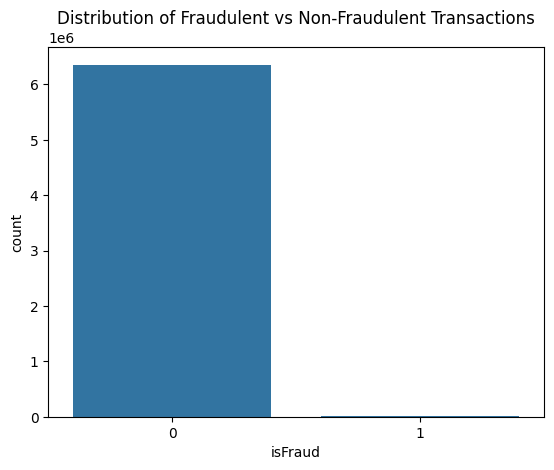

In [9]:
# Distribution of target variable (fraud vs non-fraud)
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

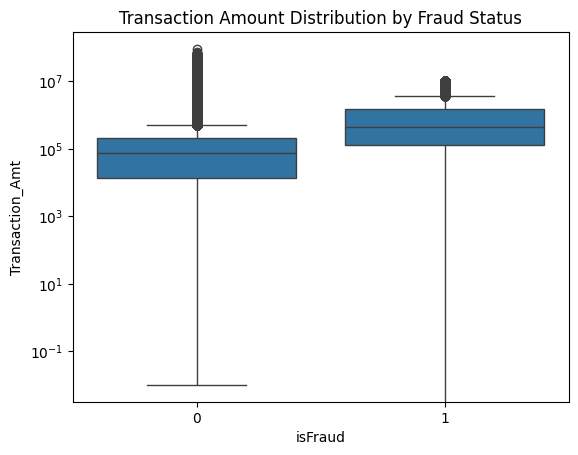

In [10]:
# Boxplot of transaction amount by fraud status (use correct column names)
sns.boxplot(x='isFraud', y='Transaction_Amt', data=df)
plt.title('Transaction Amount Distribution by Fraud Status')
plt.yscale('log')  # Log scale for better visualization if amounts vary widely
plt.show()

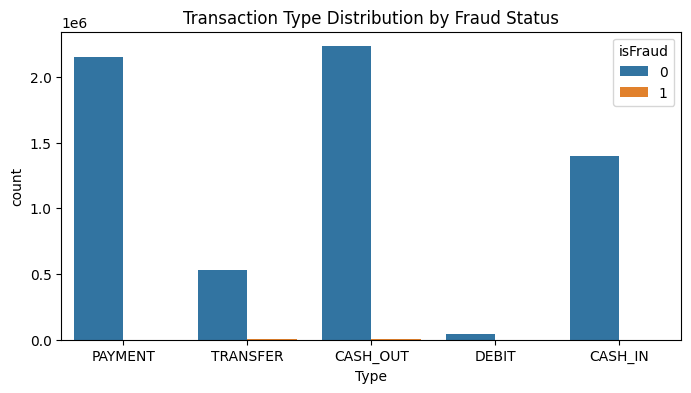

In [11]:
# Count plot of transaction type by fraud status
plt.figure(figsize=(8, 4))
sns.countplot(x='Type', hue='isFraud', data=df)
plt.title('Transaction Type Distribution by Fraud Status')
plt.show()

### Detailed EDA with Feature Distributions and Relationships

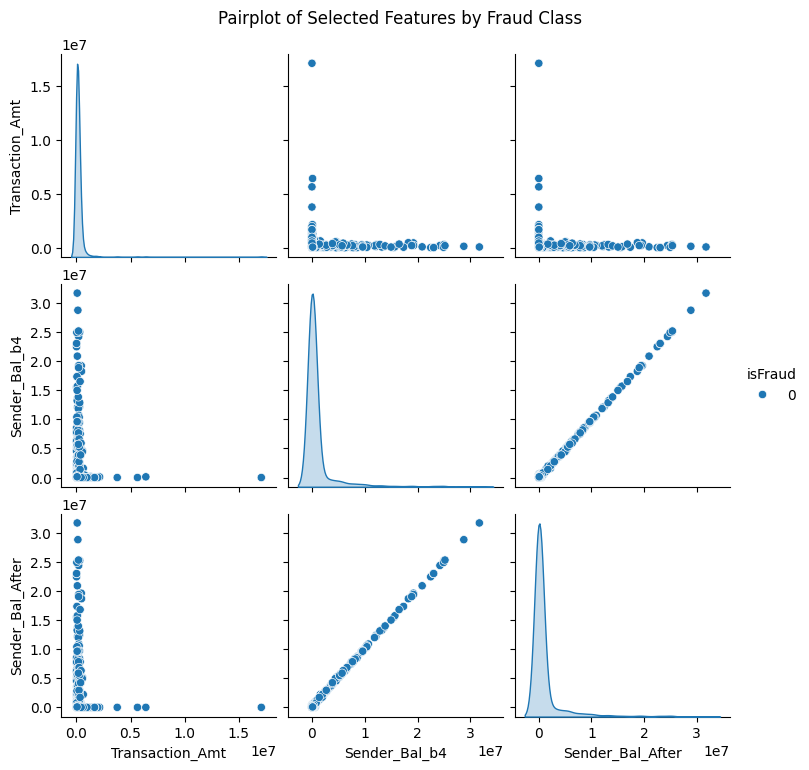

In [12]:
# Pairplot for selected numeric variables colored by fraud status
sns.pairplot(df.sample(min(1000, len(df))), vars=['Transaction_Amt', 'Sender_Bal_b4', 'Sender_Bal_After'], hue='isFraud')
plt.suptitle('Pairplot of Selected Features by Fraud Class', y=1.02)
plt.show()

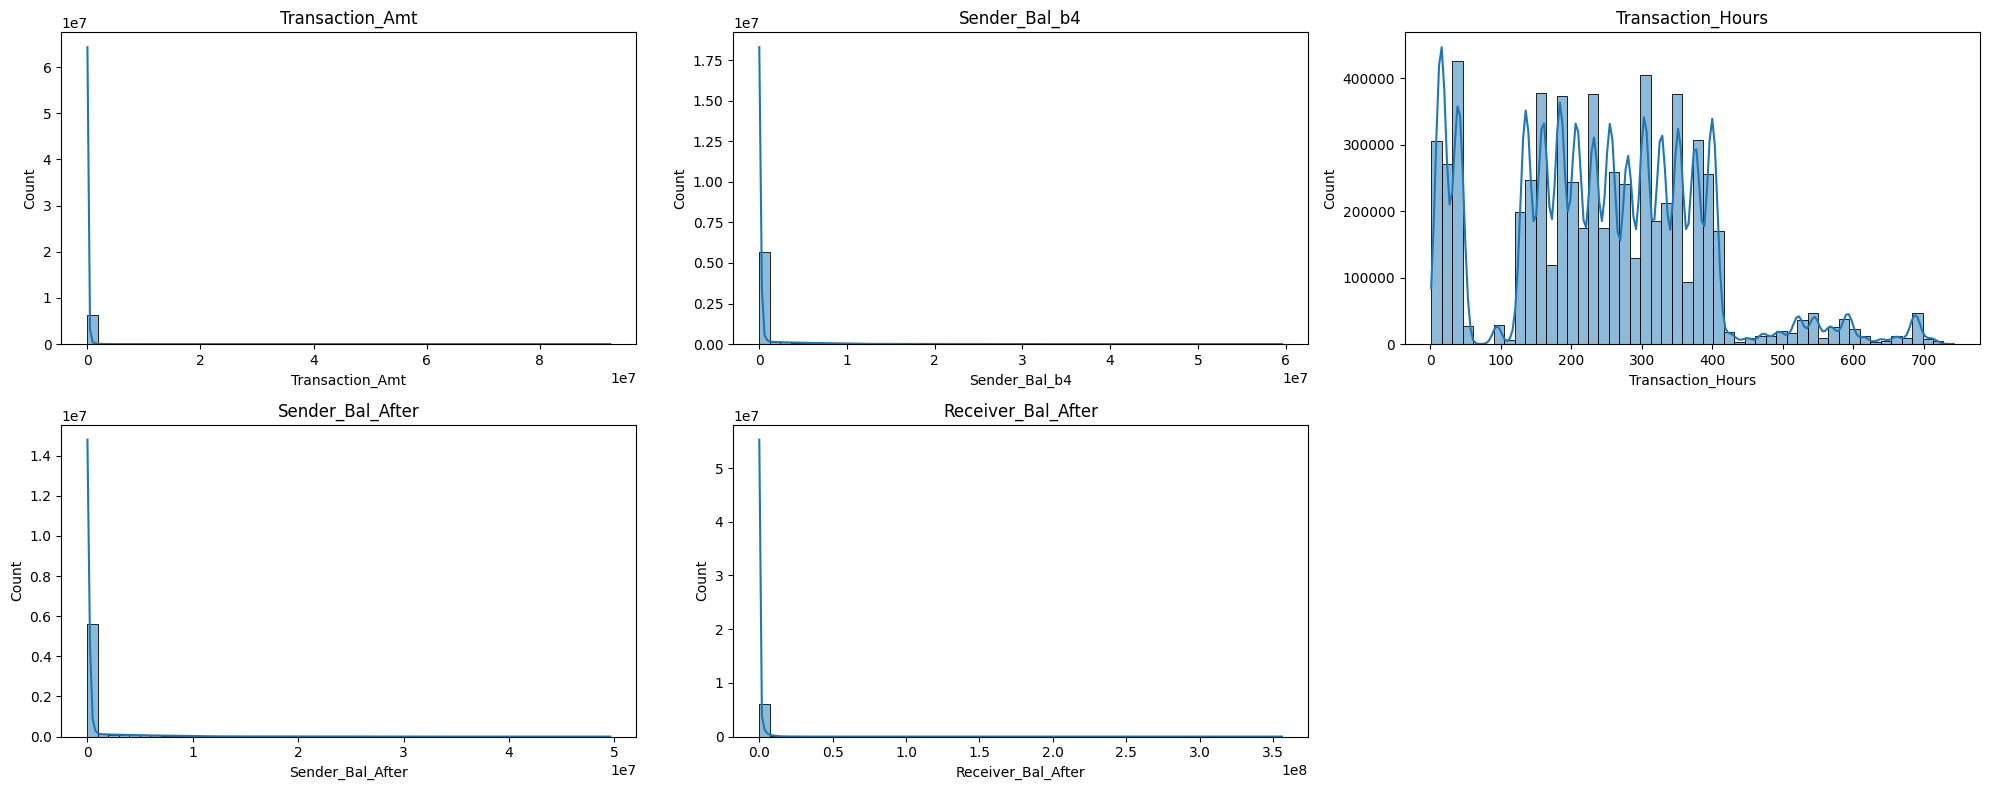

In [13]:
# Histogram plots for features list
features = ['Transaction_Amt', 'Sender_Bal_b4', 'Transaction_Hours', 'Sender_Bal_After', 'Receiver_Bal_After']

plt.figure(figsize=(20, 8))
warnings.filterwarnings("ignore")  # Ignore warnings for clean output

for idx, feature in enumerate(features, 1):
    plt.subplot(2, 3, idx)
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(feature)

plt.tight_layout()
plt.show()

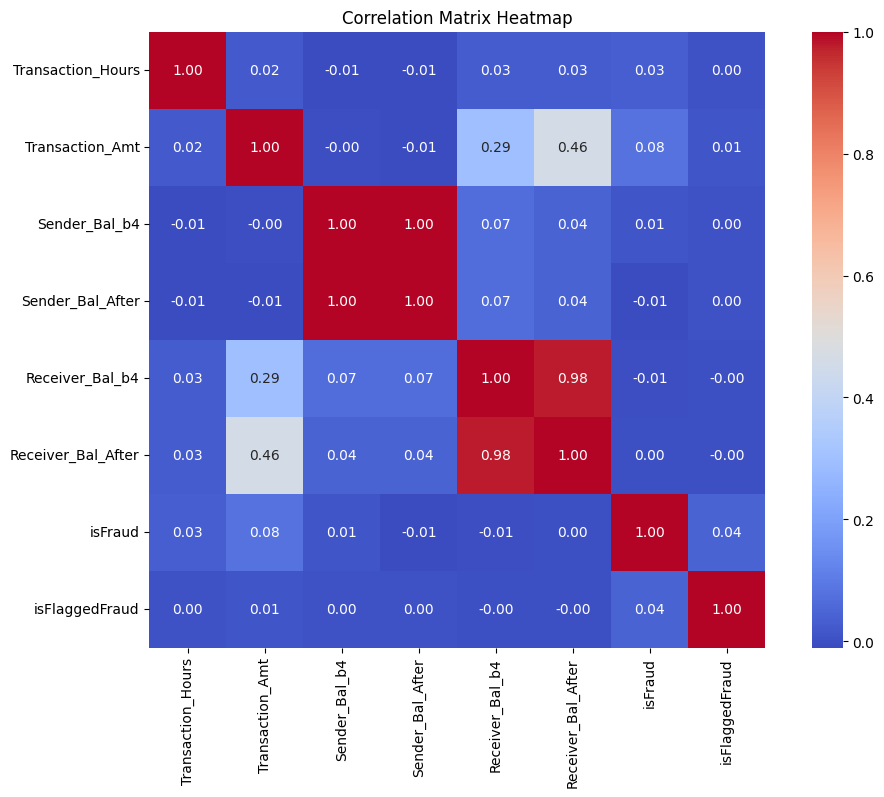

In [14]:
# Correlation matrix of numeric columns
# Select only numeric columns from df
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlation matrix on numeric columns only
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure size
plt.figure(figsize=(12, 8))

# Create a heatmap with annotations and a coolwarm color scheme
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)

# Add a title for clarity
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

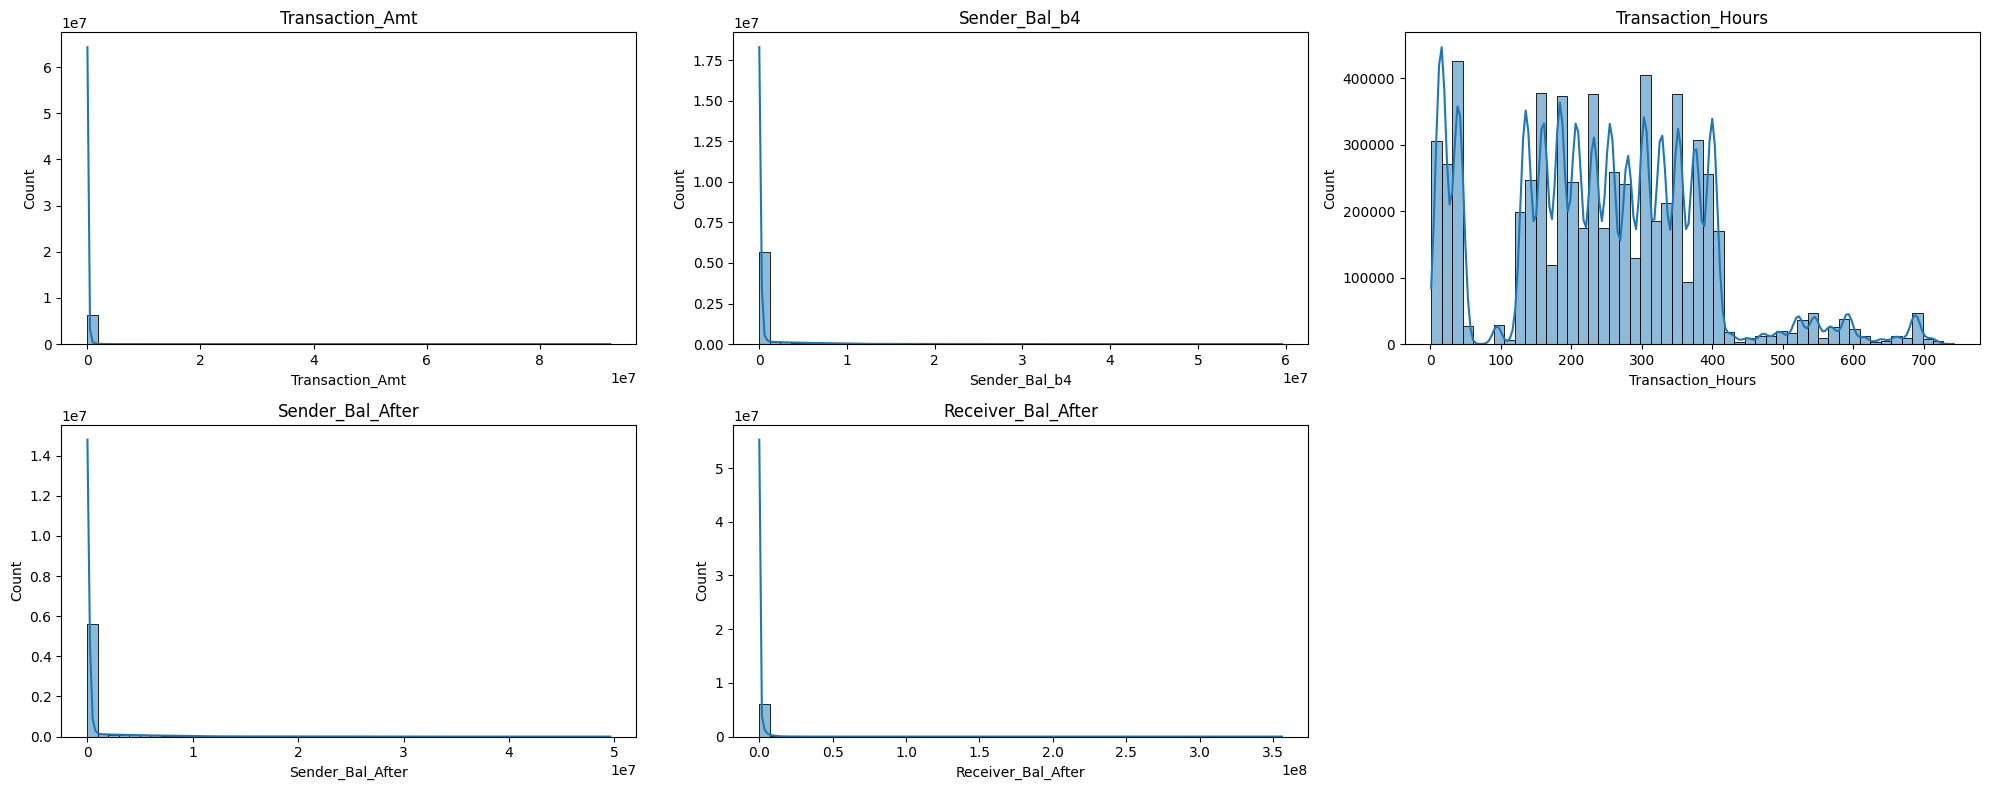

In [15]:
# Plotting all numerical features for distribution Check
plt.figure(figsize=(20, 8))
warnings.filterwarnings("ignore")
 
for idx, feature in enumerate(features, 1):  # start counting at 1
    plt.subplot(2, 3, idx)   
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(feature)

plt.tight_layout()
plt.show()

In [16]:
# Correlation between feature and target
corr = df.select_dtypes(include=['number']).corr()
print(corr['isFraud'].sort_values(ascending=False))

isFraud               1.000000
Transaction_Amt       0.076688
isFlaggedFraud        0.044109
Transaction_Hours     0.031578
Sender_Bal_b4         0.010154
Receiver_Bal_After    0.000535
Receiver_Bal_b4      -0.005885
Sender_Bal_After     -0.008148
Name: isFraud, dtype: float64


<Axes: ylabel='count'>

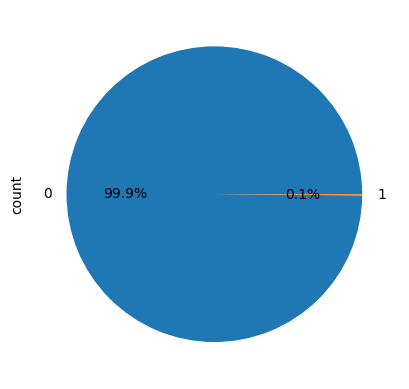

In [17]:
# Count on Fraud and Non-Fraud
df["isFraud"].value_counts().plot.pie(autopct="%1.1f%%")

In [18]:
# Dividing the dataframe into fraud and non-fraud data
non_fraud = df[df['isFraud'] == 0]
fraud = df[df['isFraud'] == 1]

In [19]:
## Dropping Some Irrelevant Columns
df = df.drop(["isFlaggedFraud", 'Sender', "Receiver"],axis=1)

In [20]:
df.columns

Index(['Transaction_Hours', 'Type', 'Transaction_Amt', 'Sender_Bal_b4',
       'Sender_Bal_After', 'Receiver_Bal_b4', 'Receiver_Bal_After', 'isFraud'],
      dtype='object')

In [21]:
## Encoding Categorical Variables
le = LabelEncoder()
df['Type']= le.fit_transform(df['Type'])

In [22]:
df.head()

,Transaction_Hours,Type,Transaction_Amt,Sender_Bal_b4,Sender_Bal_After,Receiver_Bal_b4,Receiver_Bal_After,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


In [23]:
## Now dividing the dataframe into dependent and Independent variables
x= df.drop(["isFraud"], axis=1)
y=df.isFraud

In [24]:
# Check the shape
x.shape, y.shape

((6362620, 7), (6362620,))

In [25]:
## Divide the dataset into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=99)

In [26]:
# Check the shape again
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5090096, 7), (1272524, 7), (5090096,), (1272524,))

In [27]:
## Scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [28]:
#Making data ready for CNN
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [29]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test= x_test.reshape(x_test.shape[0], x_test.shape[1])

#Check the shape again
x_train.shape, x_test.shape

((5090096, 7), (1272524, 7))

In [30]:
print("Before Oversampling, count of label '1': {}".format(sum(y_train == 1)))
print("Before Oversampling, count of label '0': {}".format(sum(y_train == 0)))

Before Oversampling, count of label '1': 6545
Before Oversampling, count of label '0': 5083551


In [31]:
## SMOTE to Handle Imbalance data

from imblearn.over_sampling import SMOTE
smote= SMOTE(random_state = 42)
x_res, y_res = smote.fit_resample(x_train, y_train.ravel())

x_res=x_res.reshape(x_res.shape[0],x_res.shape[1],1)
x_test= x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [32]:
print ('After Oversampling, the shape of train_x: {}'. format(x_res.shape))
print ('After Oversampling, the shape of train_y: {}'. format(y_res.shape))

print('After Oversampling, counts of label "1": {}'.format(sum(y_res == 1)))
print('After Oversampling, counts of label "0": {}'.format(sum(y_res == 0)))

After Oversampling, the shape of train_x: (10167102, 7, 1)
After Oversampling, the shape of train_y: (10167102,)
After Oversampling, counts of label "1": 5083551
After Oversampling, counts of label "0": 5083551


In [33]:
## Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, Dropout

## Import Model 

In [34]:
model = Sequential()

# Conv1D layer 
model.add(Conv1D(filters=32, kernel_size=2, activation="relu", input_shape=x_res[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Build ANN layers
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(1, activation="sigmoid"))

In [35]:
## Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 32)             96        
                                                                 
 batch_normalization (Batch  (None, 6, 32)             128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 6, 32)             0         
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 64)                12352     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [36]:
## Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [37]:
## Fitting the model
history = model.fit(x_res, y_res, epochs=1, validation_data=(x_test, y_test))

317722/317722 [==============================] - 888s 3ms/step - loss: 0.0525 - accuracy: 0.9825 - val_loss: 0.0423 - val_accuracy: 0.9830


In [38]:
%time history = model.fit(x_res, y_res, epochs=1, validation_data=(x_test, y_test))

317722/317722 [==============================] - 903s 3ms/step - loss: 0.0442 - accuracy: 0.9860 - val_loss: 0.0300 - val_accuracy: 0.9880
CPU times: total: 18min 22s
Wall time: 15min 3s


In [39]:
import psutil
print("CPU usage (%):", psutil.cpu_percent(interval=1))
ram = psutil.virtual_memory()
print("RAM usage (%):", ram.percent)
print("RAM used (GB):", round(ram.used / 1e9, 2))

CPU usage (%): 5.0
RAM usage (%): 84.7
RAM used (GB): 14.27


## Serialize model2 to JSON and save to file

In [40]:
import os
model_dir = "C:/AI/Practice/BFloat16-Poc"
os.makedirs(model_dir, exist_ok=True)

model_json = model.to_json()
with open(os.path.join(model_dir, "model.json"), "w") as json_file:
    json_file.write(model_json)

model.save_weights(os.path.join(model_dir, "model.h5"))
print("Saved model to disk")


Saved model to disk


# BFloat-16

In [41]:
## import the libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, Dropout

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Dense

model2 = Sequential()

model2.add(Conv1D(filters=32, kernel_size=2, activation="relu", input_shape=x_res[0].shape))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

model2.add(Conv1D(filters=64, kernel_size=2, activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Add a Flatten layer if you want to connect Conv1D output to Dense
model2.add(Flatten())

model2.add(Dense(1, activation="relu"))  # For binary classification typically "sigmoid" is used

In [43]:
## converting model weights to BFloat16 data type
import tensorflow as tf

policy = tf.keras.mixed_precision.Policy("mixed_bfloat16")
tf.keras.mixed_precision.set_global_policy(policy)

In [44]:
## Coverting input data to BFLOAT16 data Type
X_train_bfloat = tf.convert_to_tensor(x_res, dtype=tf.bfloat16)

In [45]:
X_train_bfloat.shape

TensorShape([10167102, 7, 1])

In [46]:
# Convert  test data to bfloat16 data type
x_test_bfloat = tf.convert_to_tensor(x_test, dtype=tf.bfloat16)

In [47]:
# train the model with bfloat16 data type
model2.compile(optimizer ="adam", loss= "binary_crossentropy", metrics = ["accuracy"])

### Fitting the model

In [48]:
import time

start_time = time.time()
history2 = model2.fit(X_train_bfloat, y_res, epochs=1, validation_data=(x_test_bfloat, y_test))
end_time = time.time()

print(f"Training time: {end_time - start_time} seconds")

317722/317722 [==============================] - 1254s 4ms/step - loss: 0.6237 - accuracy: 0.9402 - val_loss: 0.1343 - val_accuracy: 0.9693
Training time: 1254.5402603149414 seconds


In [49]:
 %time history2 = model2.fit(X_train_bfloat, y_res, epochs=1, validation_data=(x_test_bfloat, y_test))

317722/317722 [==============================] - 1044s 3ms/step - loss: 0.1660 - accuracy: 0.9599 - val_loss: 0.0887 - val_accuracy: 0.9688
CPU times: total: 23min 30s
Wall time: 17min 24s


In [50]:
import psutil
print("CPU usage (%):", psutil.cpu_percent(interval=1))
ram = psutil.virtual_memory()
print("RAM usage (%):", ram.percent)
print("RAM used (GB):", round(ram.used / 1e9, 2))


CPU usage (%): 16.5
RAM usage (%): 64.9
RAM used (GB): 10.94


### Serialize model2 to JSON and save to file

In [51]:
import os

model_dir = r"C:\AI\Practice\BFloat16 -poC"
os.makedirs(model_dir, exist_ok=True)  # This creates the directory if not already present

model_json2 = model2.to_json()
with open(os.path.join(model_dir, "model2.json"), "w") as json_file:
    json_file.write(model_json2)

model2.save_weights(os.path.join(model_dir, "model2.h5"))
print("Saved model to disk")

Saved model to disk


## Summary
- #### BFloat16 significantly reduces memory usage (~23% less) and CPU load while maintaining strong accuracy, making it well-suited for scalable fraud detection tasks. However, FP32 delivers slightly better accuracy and faster training runtime.